In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.random_projection import GaussianRandomProjection

#### spam data

In [2]:
spam_path = '../Project 1/spam/'

In [3]:
with open(os.path.join(spam_path, 'spambase.names')) as f:
    names = f.readlines()
cols = [c for c in names if c[0] != '|']
cols = [c.replace('\n', '') for c in cols]
cols = [c.split(':')[0] for c in cols]
cols = [c for c in cols if c]
spam_cols = cols[1:]

In [4]:
df_spam = pd.read_csv(os.path.join(spam_path, 'spambase.data'), header=None)

In [5]:
X_spam_cols = df_spam.columns[:-1]
y_spam_col = df_spam.columns.difference(X_spam_cols)[0]
X_spam = df_spam[X_spam_cols]
y_spam = df_spam[y_spam_col]

In [6]:
X_spam_train, X_spam_test, y_spam_train, y_spam_test = train_test_split(
    X_spam, y_spam, stratify=y_spam, train_size=.8, shuffle=True, random_state=42
)

In [7]:
ss = StandardScaler()
x_cols = X_spam.columns
X_spam_train = ss.fit_transform(X_spam_train)
X_spam_test = ss.transform(X_spam_test)

#### visualize cluster

In [8]:
def viz_clusters(X, clusters, i=0, j=1):
    pca = PCA()
    x = pca.fit_transform(X)
    x1 = x[:, i]
    x2 = x[:, j]
    fig, ax = plt.subplots(figsize=(16,9))
    plot = ax.scatter(x1, x2, c=clusters, alpha=.2)
    var1 = round(pca.explained_variance_ratio_[i], 2)
    var2 = round(pca.explained_variance_ratio_[j], 2)
    ax.set_xlabel(f'PCA Component {i} - Percent Explained Variance {var1}')
    ax.set_ylabel(f'PCA Component {j} - Percent Explained Variance {var2}')
    leg = ax.legend(*plot.legend_elements())
    for lh in leg.legendHandles:
        lh._legmarker.set_alpha(1)

In [9]:
def elbow_plot(scores, metric, figsize=(5,3)):
    scores = pd.Series(scores)
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(scores.index, scores.values)
    ax.set_title('Elbow Plot')
    ax.set_ylabel(metric.title())
    ax.set_xlabel('K')

In [10]:
def calc_silhouette(d, c, alg):
    if alg == 'soft':
        n, m = c.shape
        scores = np.zeros(c.shape)
        for i in range(m):
            a = (d * c[:, i]).sum(axis=1) / np.dot(1-np.eye(n), c[:,i])
            b = np.zeros((n, m-1))
            for j in range(m):
                if i == j:
                    continue
                idx = j - (1 * (j > i))
                b[:, idx] = (d * c[:, j]).sum(axis=1) / np.dot(1-np.eye(n), c[:,j])
            b = b.min(axis=1)
            scores[:, i] = (b - a)/np.array([a, b]).max(axis=0)
        score = (scores * c).sum() / c.sum()
    elif alg == 'hard':
        if len(c.shape) > 1:
            if c.shape[1] > 1:
                c = c.argmax(axis=1)
            elif c.shape[1] == 1:
                c = c.reshape(-1)
        score = silhouette_score(d, c, metric='precomputed')
    return score

#### spam prep

In [11]:
results = {
    'em_spam_pca': {'log_likelihood': '', 'final': {'silhouette': '', 'information_gain': ''}},
    'km_spam_pca': {'silhouette': '', 'final': {'silhouette': '', 'information_gain': ''}},
    'em_spam_ica': {'log_likelihood': '', 'final': {'silhouette': '', 'information_gain': ''}},
    'km_spam_ica': {'silhouette': '', 'final': {'silhouette': '', 'information_gain': ''}},
    'em_spam_rp': {'log_likelihood': '', 'final': {'silhouette': '', 'information_gain': ''}},
    'km_spam_rp': {'silhouette': '', 'final': {'silhouette': '', 'information_gain': ''}},
    'em_spam_rf': {'log_likelihood': '', 'final': {'silhouette': '', 'information_gain': ''}},
    'km_spam_rf': {'silhouette': '', 'final': {'silhouette': '', 'information_gain': ''}},
}
X = X_spam_train.copy()
y = y_spam_train.copy()
X_val = X_spam_test.copy()

#### reduce data - spam

In [12]:
pca = PCA(2, random_state=4200)
X_pca = pca.fit_transform(X)
X_val_pca = pca.transform(X_val)

In [13]:
ica = FastICA(5, random_state=4200)
X_ica = ica.fit_transform(X)
X_val_ica = ica.transform(X_val)

In [14]:
rp = GaussianRandomProjection(10, random_state=4200)
X_rp = rp.fit_transform(X)
X_val_rp = rp.transform(X_val)

In [15]:
# random forest
X_rf = X[:, [52, 51, 6]].copy()
X_val_rf = X_val[:, [52, 51, 6]].copy()

#### distance - spam

In [16]:
dist_pca = distance_matrix(X_pca, X_pca)
dist_ica = distance_matrix(X_ica, X_ica)
dist_rp = distance_matrix(X_rp, X_rp)
dist_rf = distance_matrix(X_rf, X_rf)

#### clustering - EM PCA spam

In [17]:
X = X_pca.copy()
X_val = X_val_pca.copy()
y = y.copy()
dist = dist_pca
model = GaussianMixture
alg = 'soft'
fname = 'em_spam_pca.csv'

In [18]:
# generate data
seed = 42
min_k = 2
max_k = 10
df = pd.DataFrame(index=range(X.shape[0]))
models = {}
for k in range(min_k, max_k+1):
    model_k = model(k, random_state=seed)
    model_k.fit(X)
    models[k] = model_k
    y_pred = model_k.predict_proba(X)
    cols = [f'{k}_{i}' for i in range(k)]
    for i, col in enumerate(cols):
        df[col] = y_pred[:, i]

In [19]:
# save results (and add label)
df['label'] = y.values
df.to_csv(os.path.join('./results/', fname))

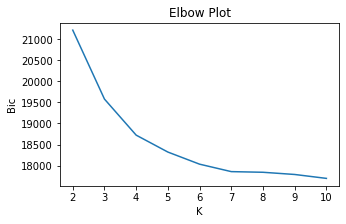

In [20]:
# choose k - BIC
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = models[k].bic(X)
elbow_plot(scores, 'BIC')

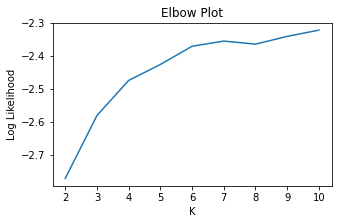

In [21]:
# choose k - log likelihood
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = models[k].score(X_val)
results[fname.replace('.csv', '')]['log_likelihood'] = scores
elbow_plot(scores, 'Log Likelihood')

In [22]:
pd.concat([df.filter(like='6_').mean(), df.filter(like='6_').idxmax(axis=1).value_counts(normalize=True)], axis=1)

,0,1
6_0,0.510875,0.586957
6_1,0.004426,0.004348
6_2,0.092771,0.073370
6_3,0.125974,0.114946
6_4,0.026212,0.020924
6_5,0.239741,0.199457


In [23]:
# choose k
k = 6
alt_k = 4
k_cols = df.filter(like=f'{k}_').columns
alt_k_cols = df.filter(like=f'{alt_k}_').columns

In [24]:
# validate - silhouette
sil = calc_silhouette(dist, df[k_cols].values, alg)
results[fname.replace('.csv', '')]['final']['silhouette'] = sil
sil

0.027555728812740286

In [25]:
calc_silhouette(dist, df[alt_k_cols].values, alg)

0.011225982769673142

In [26]:
# validate - labels mean
print(round(df['label'].mean(), 3), '\n')
print((df[k_cols].apply(lambda x: x * df['label']).sum() / df[k_cols].sum()).round(3))

0.394 

6_0    0.524
6_1    0.000
6_2    0.874
6_3    0.042
6_4    0.011
6_5    0.166
dtype: float64


In [27]:
print(round(df['label'].mean(), 3), '\n')
print((df[alt_k_cols].apply(lambda x: x * df['label']).sum() / df[alt_k_cols].sum()).round(3))

0.394 

4_0    0.137
4_1    0.012
4_2    0.516
4_3    0.387
dtype: float64


In [28]:
# validate - information gain
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df[k_cols].apply(lambda x: x * df['label']).sum() / df[k_cols].sum()
q = df[k_cols].apply(lambda x: x * (1-df['label'])).sum() / df[k_cols].sum()
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[k_cols].mean()).sum()
ig = h1 - h2
results[fname.replace('.csv', '')]['final']['information_gain'] = ig
ig

0.21759684616206554

In [29]:
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df[alt_k_cols].apply(lambda x: x * df['label']).sum() / df[alt_k_cols].sum()
q = df[alt_k_cols].apply(lambda x: x * (1-df['label'])).sum() / df[alt_k_cols].sum()
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[alt_k_cols].mean()).sum()
ig = h1 - h2
ig

0.10272292356282053

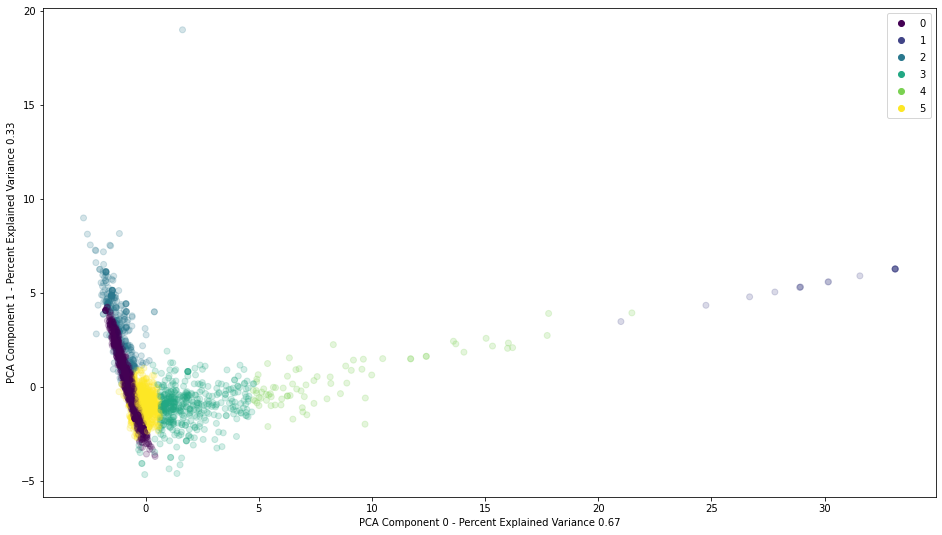

In [30]:
# visualize clusters
viz_clusters(X, df[k_cols].idxmax(axis=1).map(lambda x: x[2:]).astype(int))

#### clustering - K Means PCA spam

In [31]:
X = X_pca.copy()
y = y.copy()
X_val = X_val_pca.copy()
dist = dist_pca
model = KMeans
alg = 'hard'
fname = 'km_spam_pca.csv'

In [32]:
# generate data
seed = 42
min_k = 2
max_k = 10
df = pd.DataFrame(index=range(X.shape[0]))
models = {}
for k in range(min_k, max_k+1):
    model_k = model(k, random_state=seed)
    model_k.fit(X)
    models[k] = model_k
    y_pred = model_k.predict(X)
    col = k
    df[col] = y_pred

In [33]:
# save results (and add label)
df['label'] = y.values
df.to_csv(os.path.join('./results/', fname))

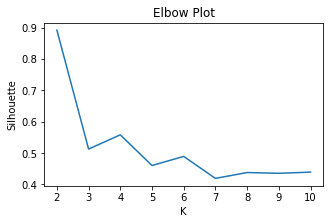

In [34]:
# choose k - silhouette
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = silhouette_score(dist, df[k], metric='precomputed')
results[fname.replace('.csv', '')]['silhouette'] = scores
elbow_plot(scores, 'Silhouette')

In [35]:
df[4].value_counts(normalize=True)

0    0.692935
2    0.258696
3    0.043207
1    0.005163
Name: 4, dtype: float64

In [36]:
df[6].value_counts(normalize=True)

0    0.519293
3    0.292663
2    0.112228
4    0.063043
5    0.008152
1    0.004620
Name: 6, dtype: float64

In [37]:
# choose k
k = 4
alt_k = 6
k_cols = df.filter(like=f'{k}').columns
alt_k_cols = df.filter(like=f'{alt_k}').columns

In [38]:
# validate - silhouette
sil = calc_silhouette(dist, df[k].values, alg)
results[fname.replace('.csv', '')]['final']['silhouette'] = sil
sil

0.5580704816806474

In [39]:
calc_silhouette(dist, df[alt_k].values, alg)

0.4891868616832548

In [40]:
# validate - labels mean
print(round(df['label'].mean(), 3), '\n')
print(df.groupby(k)['label'].mean().round(3))

0.394 

4
0    0.223
1    0.000
2    0.924
3    0.013
Name: label, dtype: float64


In [41]:
print(round(df['label'].mean(), 3), '\n')
print(df.groupby(alt_k)['label'].mean().round(3))

0.394 

6
0    0.112
1    0.000
2    0.952
3    0.780
4    0.013
5    0.000
Name: label, dtype: float64


In [42]:
# validate - information gain
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df.groupby(k)['label'].mean()
q = 1 - p
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[k].value_counts(normalize=True)).sum()
ig = h1 - h2
results[fname.replace('.csv', '')]['final']['information_gain'] = ig
ig

/Users/dan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.3329283575590891

In [43]:
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df.groupby(alt_k)['label'].mean()
q = 1 - p
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[alt_k].value_counts(normalize=True)).sum()
ig = h1 - h2
ig

0.44447904257606874

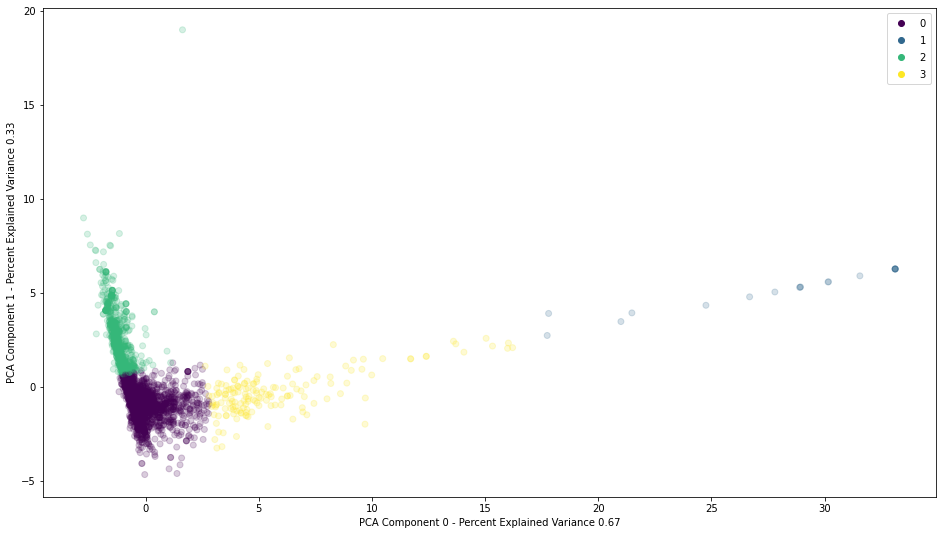

In [44]:
# visualize clusters
viz_clusters(X, df[k])

#### clustering - EM ICA spam

In [45]:
X = X_ica.copy()
X_val = X_val_ica.copy()
y = y.copy()
dist = dist_ica
model = GaussianMixture
alg = 'soft'
fname = 'em_spam_ica.csv'

In [46]:
# generate data
seed = 42
min_k = 2
max_k = 10
df = pd.DataFrame(index=range(X.shape[0]))
models = {}
for k in range(min_k, max_k+1):
    model_k = model(k, random_state=seed)
    model_k.fit(X)
    models[k] = model_k
    y_pred = model_k.predict_proba(X)
    cols = [f'{k}_{i}' for i in range(k)]
    for i, col in enumerate(cols):
        df[col] = y_pred[:, i]

In [47]:
# save results (and add label)
df['label'] = y.values
df.to_csv(os.path.join('./results/', fname))

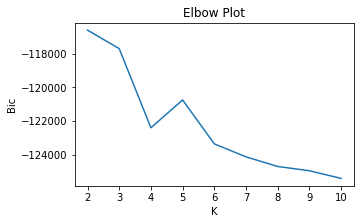

In [48]:
# choose k - BIC
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = models[k].bic(X)
elbow_plot(scores, 'BIC')

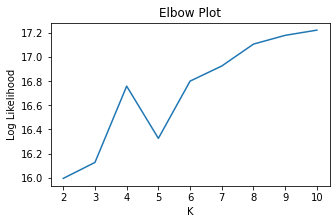

In [49]:
# choose k - log likelihood
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = models[k].score(X_val)
results[fname.replace('.csv', '')]['log_likelihood'] = scores
elbow_plot(scores, 'Log Likelihood')

In [50]:
pd.concat([df.filter(like='4_').mean(), df.filter(like='4_').idxmax(axis=1).value_counts(normalize=True)], axis=1)

,0,1
4_0,0.063072,0.060598
4_1,0.609590,0.628261
4_2,0.199091,0.194565
4_3,0.128248,0.116576


In [51]:
# choose k
k = 4
alt_k = 5
k_cols = df.filter(like=f'{k}_').columns
alt_k_cols = df.filter(like=f'{alt_k}_').columns

In [52]:
# validate - silhouette
sil = calc_silhouette(dist, df[k_cols].values, alg)
results[fname.replace('.csv', '')]['final']['silhouette'] = sil
sil

0.1936561856707477

In [53]:
calc_silhouette(dist, df[alt_k_cols].values, alg)

0.06905650081977821

In [54]:
# validate - labels mean
print(round(df['label'].mean(), 3), '\n')
print((df[k_cols].apply(lambda x: x * df['label']).sum() / df[k_cols].sum()).round(3))

0.394 

4_0    0.140
4_1    0.448
4_2    0.038
4_3    0.816
dtype: float64


In [55]:
print(round(df['label'].mean(), 3), '\n')
print((df[alt_k_cols].apply(lambda x: x * df['label']).sum() / df[alt_k_cols].sum()).round(3))

0.394 

5_0    0.196
5_1    0.513
5_2    0.049
5_3    1.000
5_4    0.032
dtype: float64


In [56]:
# validate - information gain
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df[k_cols].apply(lambda x: x * df['label']).sum() / df[k_cols].sum()
q = df[k_cols].apply(lambda x: x * (1-df['label'])).sum() / df[k_cols].sum()
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[k_cols].mean()).sum()
ig = h1 - h2
results[fname.replace('.csv', '')]['final']['information_gain'] = ig
ig

0.19127302777321953

In [57]:
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df[alt_k_cols].apply(lambda x: x * df['label']).sum() / df[alt_k_cols].sum()
q = df[alt_k_cols].apply(lambda x: x * (1-df['label'])).sum() / df[alt_k_cols].sum()
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[alt_k_cols].mean()).sum()
ig = h1 - h2
ig

0.1334884678104553

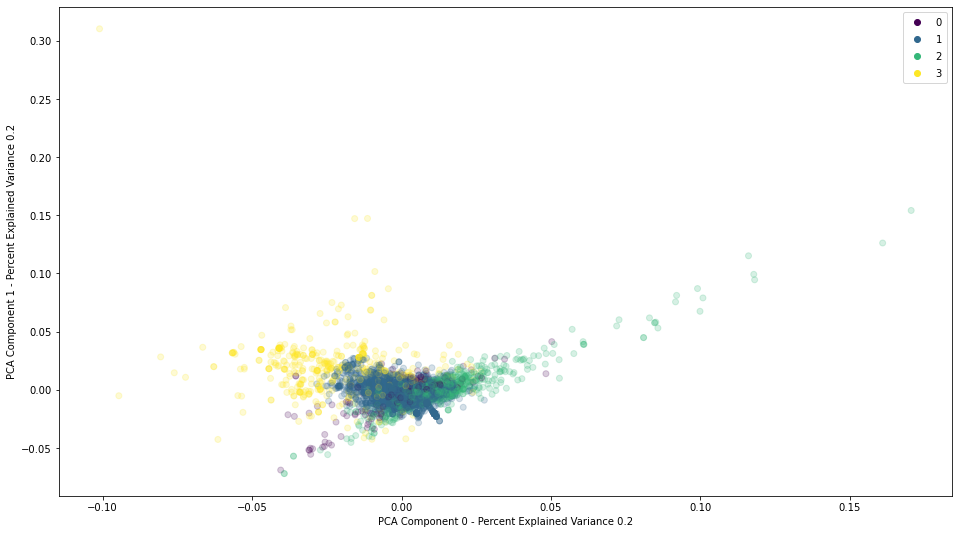

In [58]:
# visualize clusters
viz_clusters(X, df[k_cols].idxmax(axis=1).map(lambda x: x[2:]).astype(int))

#### clustering - K Means ICA spam

In [59]:
X = X_ica.copy()
y = y.copy()
X_val = X_val_ica.copy()
dist = dist_ica
model = KMeans
alg = 'hard'
fname = 'km_spam_ica.csv'

In [60]:
# generate data
seed = 42
min_k = 2
max_k = 10
df = pd.DataFrame(index=range(X.shape[0]))
models = {}
for k in range(min_k, max_k+1):
    model_k = model(k, random_state=seed)
    model_k.fit(X)
    models[k] = model_k
    y_pred = model_k.predict(X)
    col = k
    df[col] = y_pred

In [61]:
# save results (and add label)
df['label'] = y.values
df.to_csv(os.path.join('./results/', fname))

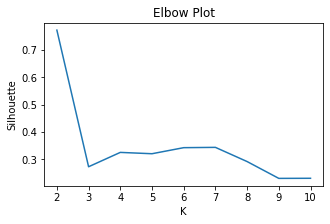

In [62]:
# choose k - silhouette
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = silhouette_score(dist, df[k], metric='precomputed')
results[fname.replace('.csv', '')]['silhouette'] = scores
elbow_plot(scores, 'Silhouette')

In [63]:
df[4].value_counts(normalize=True)

2    0.681522
1    0.230435
3    0.080707
0    0.007337
Name: 4, dtype: float64

In [64]:
df[7].value_counts(normalize=True)

0    0.654348
1    0.235598
5    0.076359
6    0.013587
3    0.012500
2    0.007337
4    0.000272
Name: 7, dtype: float64

In [65]:
# choose k
k = 4
alt_k = 7
k_cols = df.filter(like=f'{k}').columns
alt_k_cols = df.filter(like=f'{alt_k}').columns

In [66]:
# validate - silhouette
sil = calc_silhouette(dist, df[k].values, alg)
results[fname.replace('.csv', '')]['final']['silhouette'] = sil
sil

0.3255208447580647

In [67]:
calc_silhouette(dist, df[alt_k].values, alg)

0.3439002822140121

In [68]:
# validate - labels mean
print(round(df['label'].mean(), 3), '\n')
print(df.groupby(k)['label'].mean().round(3))

0.394 

4
0    0.000
1    0.915
2    0.265
3    0.030
Name: label, dtype: float64


In [69]:
print(round(df['label'].mean(), 3), '\n')
print(df.groupby(alt_k)['label'].mean().round(3))

0.394 

7
0    0.256
1    0.911
2    0.000
3    0.000
4    1.000
5    0.028
6    0.700
Name: label, dtype: float64


In [70]:
# validate - information gain
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df.groupby(k)['label'].mean()
q = 1 - p
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[k].value_counts(normalize=True)).sum()
ig = h1 - h2
results[fname.replace('.csv', '')]['final']['information_gain'] = ig
ig

/Users/dan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.2862528616130856

In [71]:
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df.groupby(alt_k)['label'].mean()
q = 1 - p
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[alt_k].value_counts(normalize=True)).sum()
ig = h1 - h2
ig

0.30242153316097964

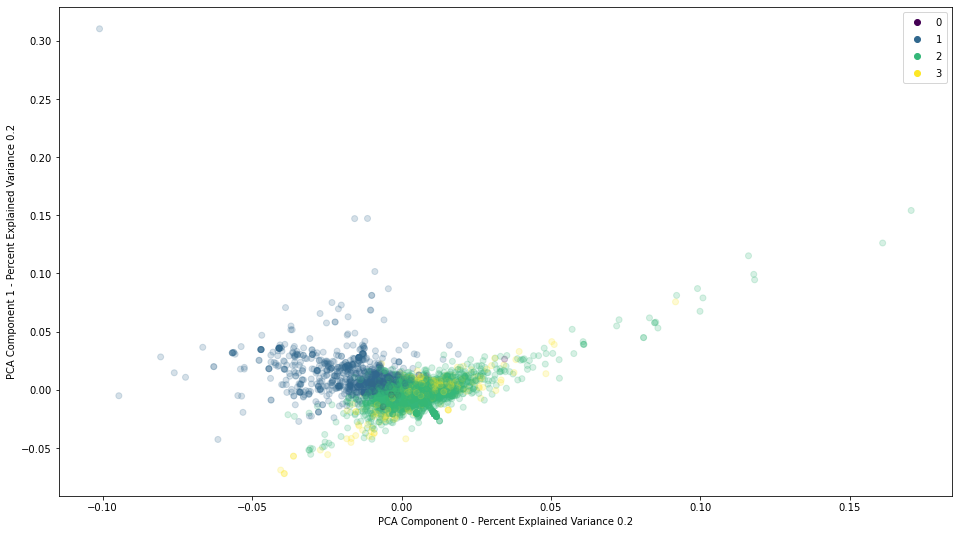

In [72]:
# visualize clusters
viz_clusters(X, df[k])

#### clustering - EM RP spam

In [73]:
X = X_rp.copy()
X_val = X_val_rp.copy()
y = y.copy()
dist = dist_rp
model = GaussianMixture
alg = 'soft'
fname = 'em_spam_rp.csv'

In [74]:
# generate data
seed = 42
min_k = 2
max_k = 10
df = pd.DataFrame(index=range(X.shape[0]))
models = {}
for k in range(min_k, max_k+1):
    model_k = model(k, random_state=seed)
    model_k.fit(X)
    models[k] = model_k
    y_pred = model_k.predict_proba(X)
    cols = [f'{k}_{i}' for i in range(k)]
    for i, col in enumerate(cols):
        df[col] = y_pred[:, i]

In [75]:
# save results (and add label)
df['label'] = y.values
df.to_csv(os.path.join('./results/', fname))

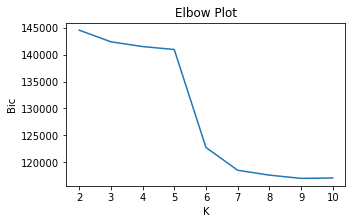

In [76]:
# choose k - BIC
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = models[k].bic(X)
elbow_plot(scores, 'BIC')

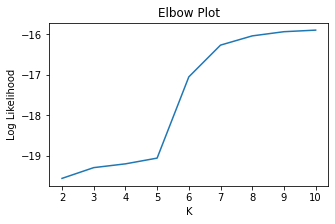

In [77]:
# choose k - log likelihood
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = models[k].score(X_val)
results[fname.replace('.csv', '')]['log_likelihood'] = scores
elbow_plot(scores, 'Log Likelihood')

In [78]:
pd.concat([df.filter(like='6_').mean(), df.filter(like='6_').idxmax(axis=1).value_counts(normalize=True)], axis=1)

,0,1
6_0,0.076086,0.076087
6_1,0.242153,0.237772
6_2,0.007880,0.007880
6_3,0.004619,0.004620
6_4,0.075703,0.075000
6_5,0.593557,0.598641


In [79]:
# choose k
k = 6
alt_k = 7
k_cols = df.filter(like=f'{k}_').columns
alt_k_cols = df.filter(like=f'{alt_k}_').columns

In [80]:
# validate - silhouette
sil = calc_silhouette(dist, df[k_cols].values, alg)
results[fname.replace('.csv', '')]['final']['silhouette'] = sil
sil

-0.004581319326351638

In [81]:
calc_silhouette(dist, df[alt_k_cols].values, alg)

-0.022259981939129522

In [82]:
# validate - labels mean
print(round(df['label'].mean(), 3), '\n')
print((df[k_cols].apply(lambda x: x * df['label']).sum() / df[k_cols].sum()).round(3))

0.394 

6_0    0.032
6_1    0.328
6_2    0.000
6_3    0.588
6_4    0.706
6_5    0.431
dtype: float64


In [83]:
print(round(df['label'].mean(), 3), '\n')
print((df[alt_k_cols].apply(lambda x: x * df['label']).sum() / df[alt_k_cols].sum()).round(3))

0.394 

7_0    0.032
7_1    0.244
7_2    0.000
7_3    0.750
7_4    0.801
7_5    0.404
7_6    0.270
dtype: float64


In [84]:
# validate - information gain
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df[k_cols].apply(lambda x: x * df['label']).sum() / df[k_cols].sum()
q = df[k_cols].apply(lambda x: x * (1-df['label'])).sum() / df[k_cols].sum()
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[k_cols].mean()).sum()
ig = h1 - h2
results[fname.replace('.csv', '')]['final']['information_gain'] = ig
ig

0.07469162342089208

In [85]:
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df[alt_k_cols].apply(lambda x: x * df['label']).sum() / df[alt_k_cols].sum()
q = df[alt_k_cols].apply(lambda x: x * (1-df['label'])).sum() / df[alt_k_cols].sum()
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[alt_k_cols].mean()).sum()
ig = h1 - h2
ig

0.15537044309309633

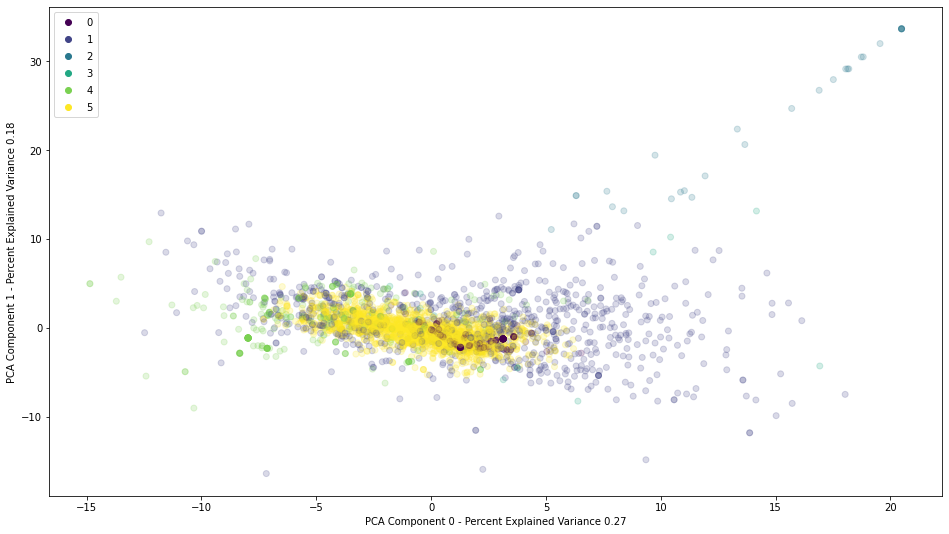

In [86]:
# visualize clusters
viz_clusters(X, df[k_cols].idxmax(axis=1).map(lambda x: x[2:]).astype(int))

#### clustering - K Means RP spam

In [87]:
X = X_rp.copy()
y = y.copy()
X_val = X_val_rp.copy()
dist = dist_rp
model = KMeans
alg = 'hard'
fname = 'km_spam_rp.csv'

In [88]:
# generate data
seed = 42
min_k = 2
max_k = 10
df = pd.DataFrame(index=range(X.shape[0]))
models = {}
for k in range(min_k, max_k+1):
    model_k = model(k, random_state=seed)
    model_k.fit(X)
    models[k] = model_k
    y_pred = model_k.predict(X)
    col = k
    df[col] = y_pred

In [89]:
# save results (and add label)
df['label'] = y.values
df.to_csv(os.path.join('./results/', fname))

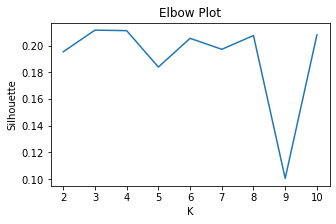

In [90]:
# choose k - silhouette
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = silhouette_score(dist, df[k], metric='precomputed')
results[fname.replace('.csv', '')]['silhouette'] = scores
elbow_plot(scores, 'Silhouette')

In [91]:
scores

{2: 0.19541948952263938,
 3: 0.2115956767021321,
 4: 0.2112041649206288,
 5: 0.18395210133171444,
 6: 0.20545680381302647,
 7: 0.1972355042765907,
 8: 0.20755033576737628,
 9: 0.10053875131810987,
 10: 0.2080035995311435}

In [92]:
df[3].value_counts(normalize=True)

0    0.606250
1    0.382065
2    0.011685
Name: 3, dtype: float64

In [93]:
df[4].value_counts(normalize=True)

0    0.554348
3    0.333152
1    0.104076
2    0.008424
Name: 4, dtype: float64

In [94]:
# choose k
k = 3
alt_k = 4
k_cols = df.filter(like=f'{k}').columns
alt_k_cols = df.filter(like=f'{alt_k}').columns

In [95]:
# validate - silhouette
sil = calc_silhouette(dist, df[k].values, alg)
results[fname.replace('.csv', '')]['final']['silhouette'] = sil
sil

0.2115956767021321

In [96]:
calc_silhouette(dist, df[alt_k].values, alg)

0.2112041649206288

In [97]:
# validate - labels mean
print(round(df['label'].mean(), 3), '\n')
print(df.groupby(k)['label'].mean().round(3))

0.394 

3
0    0.147
1    0.798
2    0.000
Name: label, dtype: float64


In [98]:
print(round(df['label'].mean(), 3), '\n')
print(df.groupby(alt_k)['label'].mean().round(3))

0.394 

4
0    0.216
1    0.029
2    0.000
3    0.815
Name: label, dtype: float64


In [99]:
# validate - information gain
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df.groupby(k)['label'].mean()
q = 1 - p
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[k].value_counts(normalize=True)).sum()
ig = h1 - h2
results[fname.replace('.csv', '')]['final']['information_gain'] = ig
ig

/Users/dan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.3248445344575548

In [100]:
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df.groupby(alt_k)['label'].mean()
q = 1 - p
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[alt_k].value_counts(normalize=True)).sum()
ig = h1 - h2
ig

0.30051603322253184

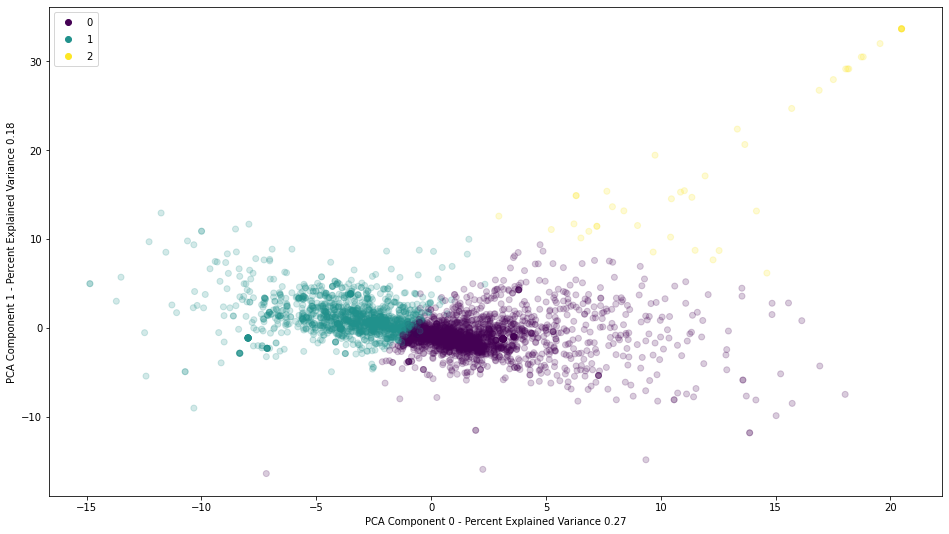

In [101]:
# visualize clusters
viz_clusters(X, df[k])

#### clustering - EM RF spam

In [102]:
X = X_rf.copy()
X_val = X_val_rf.copy()
y = y.copy()
dist = dist_rf
model = GaussianMixture
alg = 'soft'
fname = 'em_spam_rf.csv'

In [103]:
# generate data
seed = 42
min_k = 2
max_k = 10
df = pd.DataFrame(index=range(X.shape[0]))
models = {}
for k in range(min_k, max_k+1):
    model_k = model(k, random_state=seed)
    model_k.fit(X)
    models[k] = model_k
    y_pred = model_k.predict_proba(X)
    cols = [f'{k}_{i}' for i in range(k)]
    for i, col in enumerate(cols):
        df[col] = y_pred[:, i]

In [104]:
# save results (and add label)
df['label'] = y.values
df.to_csv(os.path.join('./results/', fname))

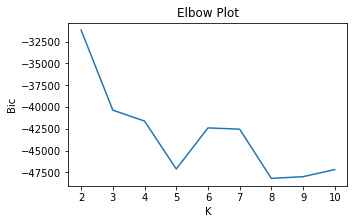

In [105]:
# choose k - BIC
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = models[k].bic(X)
elbow_plot(scores, 'BIC')

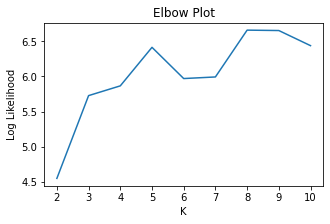

In [106]:
# choose k - log likelihood
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = models[k].score(X_val)
results[fname.replace('.csv', '')]['log_likelihood'] = scores
elbow_plot(scores, 'Log Likelihood')

In [107]:
pd.concat([df.filter(like='5_').mean(), df.filter(like='5_').idxmax(axis=1).value_counts(normalize=True)], axis=1)

,0,1
5_0,0.220494,0.219565
5_1,0.594475,0.595652
5_2,0.152858,0.156522
5_3,0.015142,0.012500
5_4,0.017032,0.015761


In [108]:
# choose k
k = 5
alt_k = 8
k_cols = df.filter(like=f'{k}_').columns
alt_k_cols = df.filter(like=f'{alt_k}_').columns

In [109]:
# validate - silhouette
sil = calc_silhouette(dist, df[k_cols].values, alg)
results[fname.replace('.csv', '')]['final']['silhouette'] = sil
sil

0.4355042824829628

In [110]:
calc_silhouette(dist, df[alt_k_cols].values, alg)

0.3955331235589028

In [111]:
# validate - labels mean
print(round(df['label'].mean(), 3), '\n')
print((df[k_cols].apply(lambda x: x * df['label']).sum() / df[k_cols].sum()).round(3))

0.394 

5_0    0.693
5_1    0.113
5_2    0.943
5_3    0.978
5_4    0.871
dtype: float64


In [112]:
print(round(df['label'].mean(), 3), '\n')
print((df[alt_k_cols].apply(lambda x: x * df['label']).sum() / df[alt_k_cols].sum()).round(3))

0.394 

8_0    0.593
8_1    0.132
8_2    0.906
8_3    0.961
8_4    0.926
8_5    1.000
8_6    0.989
8_7    0.869
dtype: float64


In [113]:
# validate - information gain
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df[k_cols].apply(lambda x: x * df['label']).sum() / df[k_cols].sum()
q = df[k_cols].apply(lambda x: x * (1-df['label'])).sum() / df[k_cols].sum()
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[k_cols].mean()).sum()
ig = h1 - h2
results[fname.replace('.csv', '')]['final']['information_gain'] = ig
ig

0.4080498481091609

In [114]:
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df[alt_k_cols].apply(lambda x: x * df['label']).sum() / df[alt_k_cols].sum()
q = df[alt_k_cols].apply(lambda x: x * (1-df['label'])).sum() / df[alt_k_cols].sum()
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[alt_k_cols].mean()).sum()
ig = h1 - h2
ig

0.39961814974154597

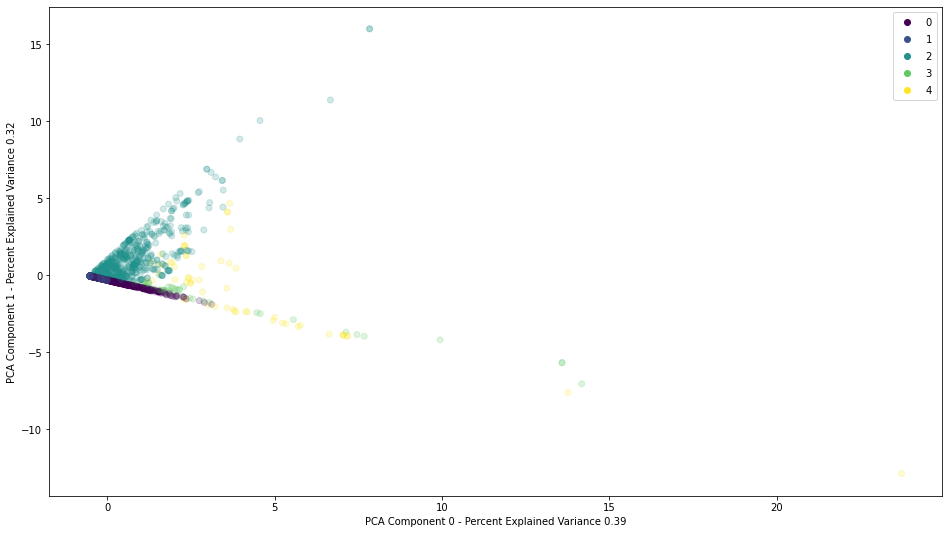

In [115]:
# visualize clusters
viz_clusters(X, df[k_cols].idxmax(axis=1).map(lambda x: x[2:]).astype(int))

#### clustering - K Means RF spam

In [116]:
X = X_rf.copy()
y = y.copy()
X_val = X_val_rf.copy()
dist = dist_rf
model = KMeans
alg = 'hard'
fname = 'km_spam_rf.csv'

In [117]:
# generate data
seed = 42
min_k = 2
max_k = 10
df = pd.DataFrame(index=range(X.shape[0]))
models = {}
for k in range(min_k, max_k+1):
    model_k = model(k, random_state=seed)
    model_k.fit(X)
    models[k] = model_k
    y_pred = model_k.predict(X)
    col = k
    df[col] = y_pred

In [118]:
# save results (and add label)
df['label'] = y.values
df.to_csv(os.path.join('./results/', fname))

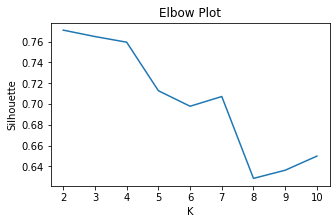

In [119]:
# choose k - silhouette
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = silhouette_score(dist, df[k], metric='precomputed')
results[fname.replace('.csv', '')]['silhouette'] = scores
elbow_plot(scores, 'Silhouette')

In [120]:
df[2].value_counts(normalize=True)

1    0.929076
0    0.070924
Name: 2, dtype: float64

In [121]:
df[7].value_counts(normalize=True)

0    0.854891
6    0.073098
4    0.050543
2    0.012228
5    0.006793
3    0.001902
1    0.000543
Name: 7, dtype: float64

In [122]:
# choose k
k = 2
alt_k = 7
k_cols = df.filter(like=f'{k}').columns
alt_k_cols = df.filter(like=f'{alt_k}').columns

In [123]:
# validate - silhouette
sil = calc_silhouette(dist, df[k].values, alg)
results[fname.replace('.csv', '')]['final']['silhouette'] = sil
sil

0.7709373955051915

In [124]:
calc_silhouette(dist, df[alt_k].values, alg)

0.7071647063363781

In [125]:
# validate - labels mean
print(round(df['label'].mean(), 3), '\n')
print(df.groupby(k)['label'].mean().round(3))

0.394 

2
0    0.950
1    0.352
Name: label, dtype: float64


In [126]:
print(round(df['label'].mean(), 3), '\n')
print(df.groupby(alt_k)['label'].mean().round(3))

0.394 

7
0    0.303
1    0.000
2    0.889
3    1.000
4    0.930
5    0.680
6    0.963
Name: label, dtype: float64


In [127]:
# validate - information gain
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df.groupby(k)['label'].mean()
q = 1 - p
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[k].value_counts(normalize=True)).sum()
ig = h1 - h2
results[fname.replace('.csv', '')]['final']['information_gain'] = ig
ig

0.07797984192766327

In [128]:
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df.groupby(alt_k)['label'].mean()
q = 1 - p
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[alt_k].value_counts(normalize=True)).sum()
ig = h1 - h2
ig

/Users/dan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.163055104717851

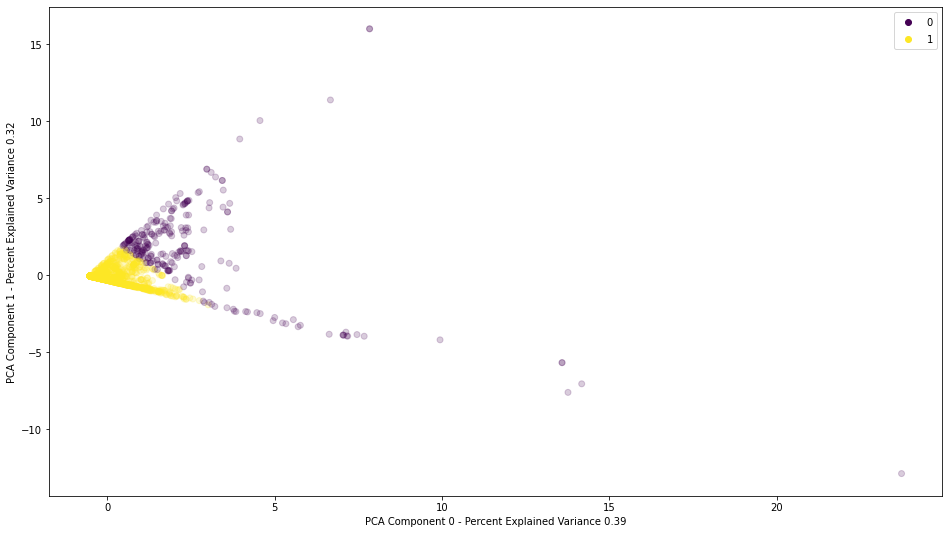

In [129]:
# visualize clusters
viz_clusters(X, df[k])

#### saving

In [130]:
for name, model_results in results.items():
    path = f'./results/{name}'
    for results_name, data in model_results.items():
        full_path = f'{path}_{results_name}.csv'
        if isinstance(data, pd.DataFrame):
            data.to_csv(full_path)
        elif isinstance(data, dict):
            pd.DataFrame(data, index=[0]).to_csv(full_path)